# Importing the Libraries

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import PIL.Image as Image
from torch.optim import optimizer
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
IMAGES_PATH = "Images/"

# Load the VGG19 model

In [8]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

c:\Users\Arnab Kumar Roy\miniconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Arnab Kumar Roy\miniconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Arnab Kumar Roy/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Load the content image

In [9]:
def load_img(img_path, img_size = 512, shape=None):
    img = Image.open(img_path).convert("RGB")

    if max(img.size) < img_size:
        img_size = max(img.size)

    if shape is not None:
        img_size = shape    

    transform = transforms.Compose([transforms.Resize(img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])
    
    return transform(img).unsqueeze(0)

In [10]:
def np_convert(tensor):
    img = tensor.to("cpu").clone().detach().numpy()
    img = img.squeeze()
    img = img.transpose(1,2,0)
    img = img * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))

    return img.clip(0,1)

In [11]:
def get_features(img, model):
    layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

    features = {}

    for name, layer in model._modules.items():
        img = layer(img)
        if name in layers:
            features[layers[name]] = img

    return features

In [12]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h*w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [16]:
content = load_img(os.path.join(IMAGES_PATH, "shrek_PNG3.png"), shape=(512, 512)).to(device)
style = load_img(os.path.join(IMAGES_PATH, "spaghetti.jpg"), shape=(512, 512)).to(device)

# Visualize the content image

(-0.5, 511.5, 511.5, -0.5)

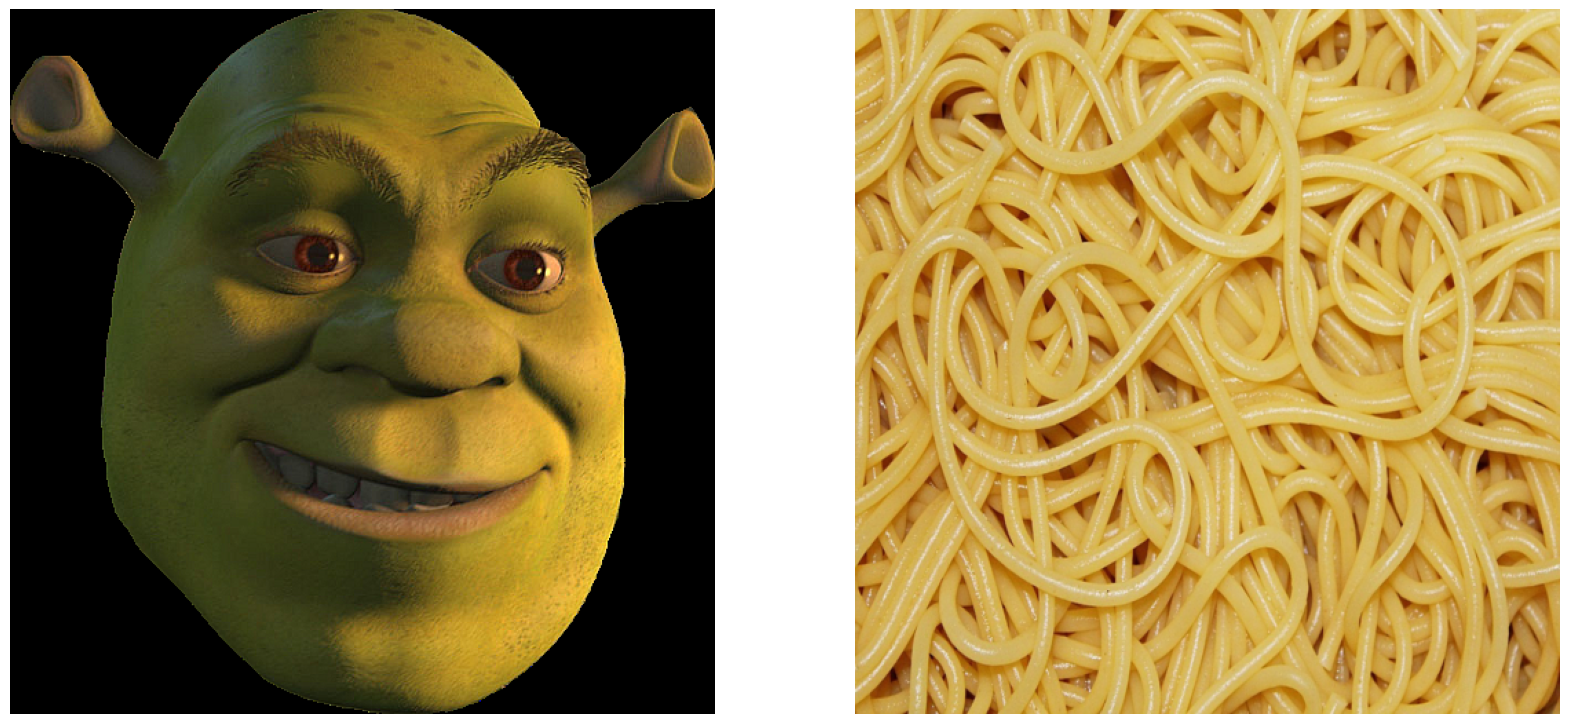

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.imshow(np_convert(content))
ax1.axis("off")
ax2.imshow(np_convert(style))
ax2.axis("off")